This script contains:

1. Importing your libraries and data¶

2. Subsetting, wrangling, and cleaning time-series data

3. Time series analysis: decomposition

4. Testing for stationarity

5. Stationarizing Data

Install the Quandl library and register for a Quandl account as described in the Exercise.

In [1]:
# importing your libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')


Find a data set to work and import it into your Jupyter notebook. Ensure that this data somehow connects to the broader research topic for your Achievement project. The best data set would be one that shares a common key with your main data set, such as a geographic component, so you can merge the data, but this could be difficult to find, so it’s not a requirement.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'JuWpjEC5zYCfM_987ztW'

In [3]:
# Importing Consumer Price Index for All Urban Consumers
data = quandl.get('FRED/CPIAUCSL')

# Note: The data originally was interested in is no longer available.

So, I looked into other similar datasets I could use for free and unfortunately ran into the same unavailable message. As a result I am conducting on FRED data for the purpose of this exercise.

Federal Reserve Economic Data, or FRED, is a project by the Economic Research department of the Federal Reserve Bank of St Louis. FRED collects over 200,000 U.S. and international economic time series, from 69 different sources, on a single website. Data coverage includes all major areas of macroeconomic analysis: growth, inflation, employment, interest rates, exchange rates, production and consumption, income and expenditure, savings and investment, and more.


Description
Growth, employment, inflation, labor, manufacturing and other US economic statistics from the research department of the Federal Reserve Bank of St. Louis.

In [4]:
# Checking the head, shape, and columns of your new dataframe for a quick overview of what you’ll be working with.
data.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [5]:
data.shape

(901, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

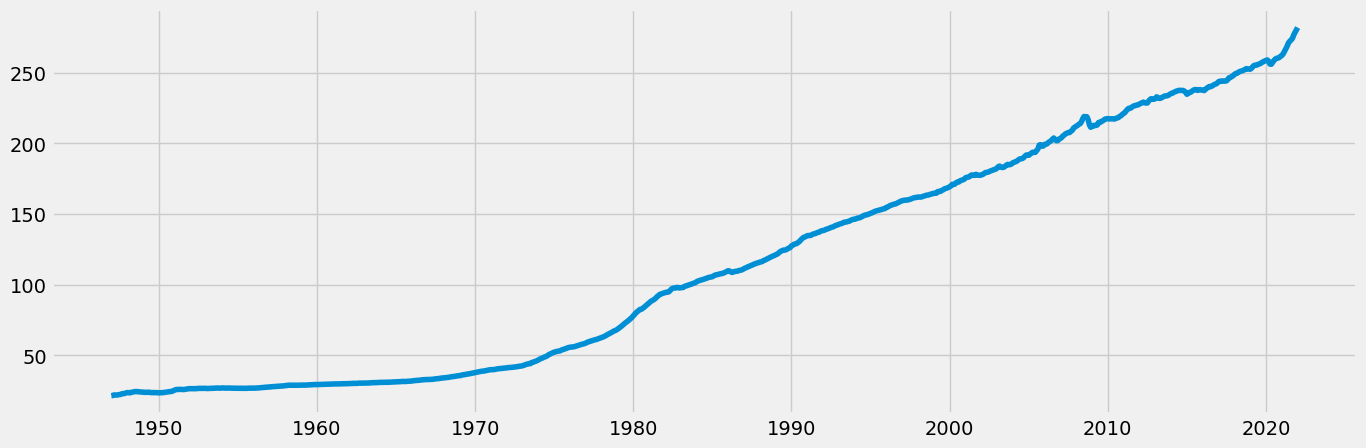

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
# The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

The data includes observations from around 1960 and up to beyond 2020, therefore creating a subset from upwards of 2000.

# 2. Subsetting, wrangling & cleaning time-series data

Make a subset of your data set if necessary. Think about the historical domain of the series to decide if you need to (if there are irrelevant historical events in your data that would bias your analysis, for example). Also, make sure your set doesn’t include any forecasted data.
In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.
Remember that if you subset your data, you’ll need to reset the index, subset, then reset the “Date” column as your index in the new dataframe.

In [9]:
# Reset index so that you can use the "Date" column as a filter

CPI_data = data.reset_index()

In [10]:
CPI_data.head()

,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


Only needing values after January 1980 and before June 2020. The former due to the fact that economic conditions in the present are different than in the 50s to 80s, so you wouldn’t want that data incorrectly influencing your calculations, and the latter due to the fact that anything after June 2020 is a prediction.

In [11]:
# creating an aoubt 20+ year  span 1980-2022
CPI_sub = CPI_data.loc[(CPI_data['Date'] >= '2000-01-01')]

In [12]:
CPI_sub.shape

(265, 2)

In [13]:
CPI_sub.head()

,Date,Value
636,2000-01-01,169.3
637,2000-02-01,170.0
638,2000-03-01,171.0
639,2000-04-01,170.9
640,2000-05-01,171.2


In [14]:
CPI_sub.tail()

,Date,Value
896,2021-09-01,274.214
897,2021-10-01,276.590
898,2021-11-01,278.524
899,2021-12-01,280.126
900,2022-01-01,281.933


In [15]:
# Set the "Date" column as the index

from datetime import datetime

CPI_sub['datetime'] = pd.to_datetime(CPI_sub['Date']) # Create a datetime column from "Date.""
CPI_sub = CPI_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
CPI_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
CPI_sub.head()

,Value
datetime,
2000-01-01,169.3
2000-02-01,170.0
2000-03-01,171.0
2000-04-01,170.9
2000-05-01,171.2


Create a line chart of your data.

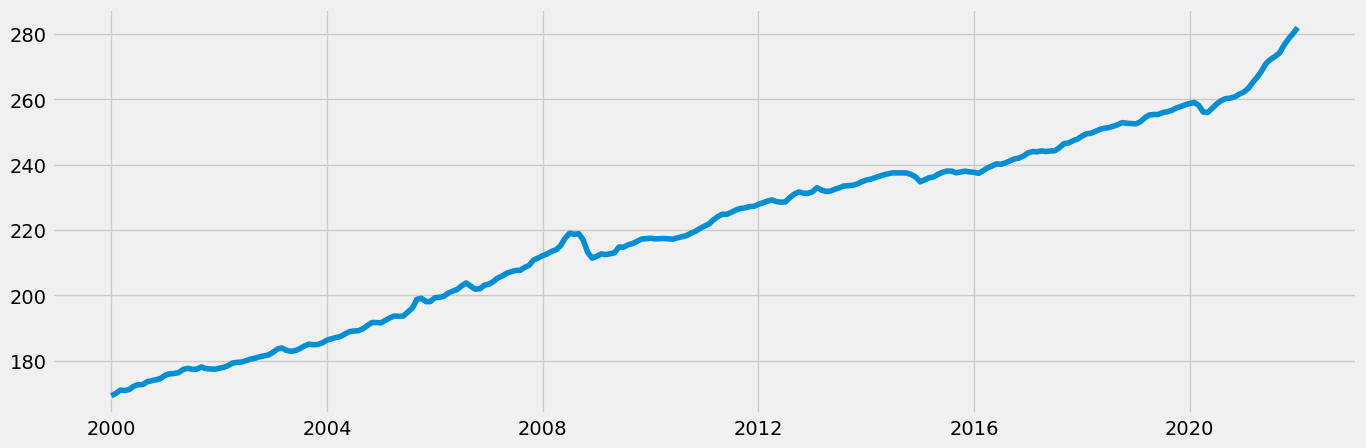

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(CPI_sub)

In [17]:
# Check for missing values (you shouldn't have any)

CPI_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = CPI_sub.duplicated()
dups.sum()



9

In [19]:
dups

datetime
2000-01-01    False
2000-02-01    False
2000-03-01    False
2000-04-01    False
2000-05-01    False
              ...  
2021-09-01    False
2021-10-01    False
2021-11-01    False
2021-12-01    False
2022-01-01    False
Length: 265, dtype: bool

In [20]:
df_dups = CPI_sub[CPI_sub.duplicated()]

In [21]:
df_dups

,Value
datetime,
2000-08-01,172.700
2001-08-01,177.400
2001-12-01,177.400
2002-01-01,177.700
2004-12-01,191.700
2005-06-01,193.700
2005-12-01,198.100
2011-06-01,224.806
2015-09-01,237.498


In [22]:
CPI_sub.shape

(265, 1)

In [23]:
df_no_dups_clean = CPI_sub.drop_duplicates()

In [24]:
df_no_dups_clean.shape

(256, 1)

Decompose the data’s components.
Analyze the results from the plot in a markdown cell.

In [25]:
# Time series analysis: decompostition
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(CPI_sub, model='additive')

In [26]:
# Define fixed size for all charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

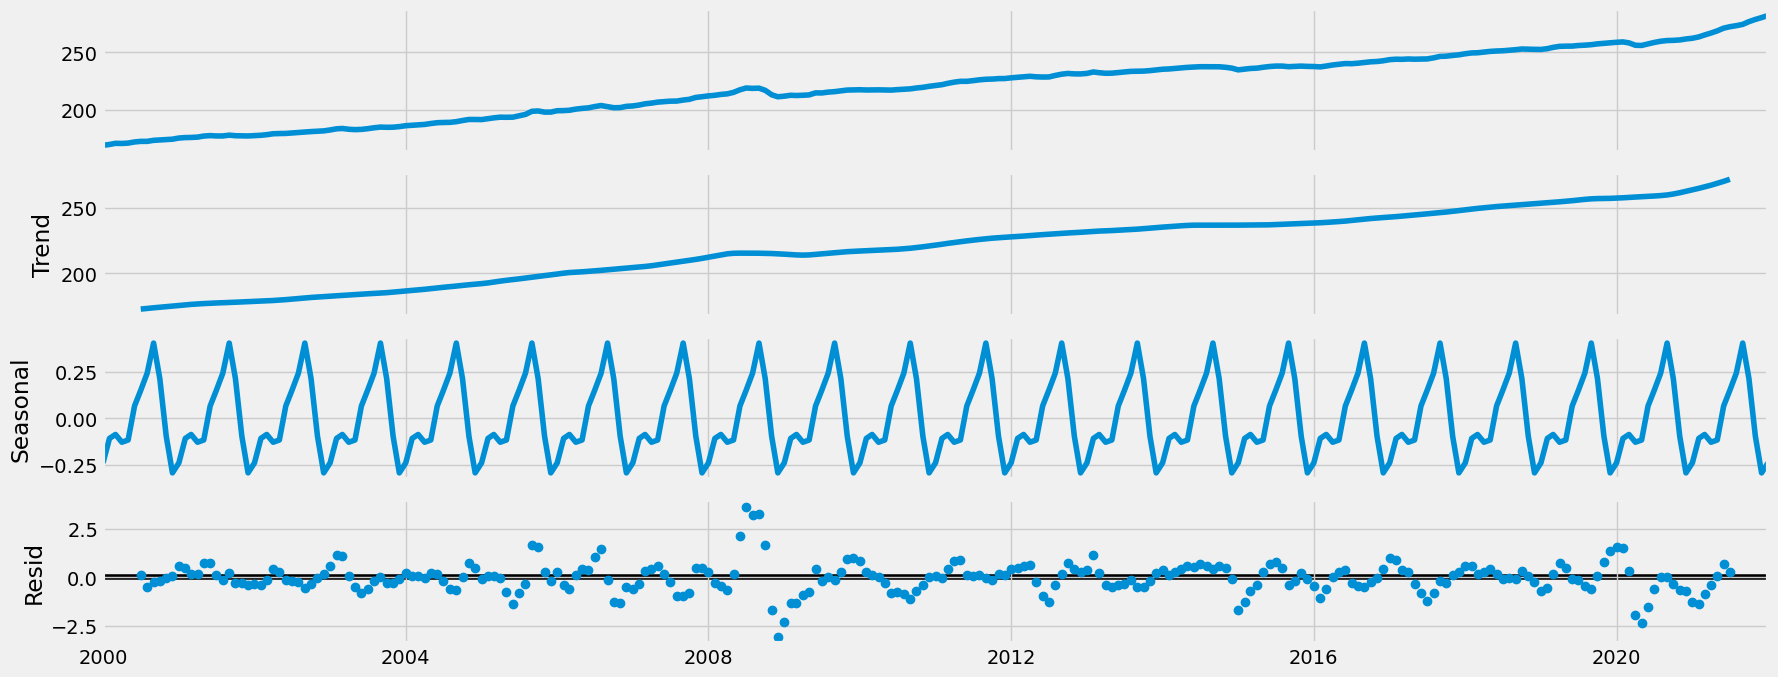

In [27]:
# Plot separate components

decomposition.plot()
plt.show()

-An upward linear trend is observed which shows that AS CPI increased, so did inflation, with two slight decreases after 2008 (economic crash) and post 2020 (due to covid)

-As seen in the decompostion, seasonality in the data is apparent by the regularly spiked intervals of the seasonal data

-Finally, the noise (residual data) is what’s left of the data after the trend and seasonality have been extracted (hence the term residual). You can see here that there isn’t much unexplained noise apart from the period of time around the 2009 financial crisis and post-covid, where there are a number of up-and-down deviations.



It’s incredibly important that you don’t skip this step when conducting a time series analysis—without separating the trend and seasonality, you can’t be sure whether you’re working with a stationary or non-stationary time series (the presence of a trend and seasonality implies the series is non-stationary), and this knowledge is essential for creating an accurate forecast. 

To summarize, there are two main factors that could prove problematic when forecasting: non-stationarity and autocorrelation.

# 4. Testing for stationarity

Conduct a Dickey-Fuller test to check for stationarity.
Interpret the results in a markdown cell and reference your null hypothesis.


When it comes to forecasting, you need data with properties that don’t change; otherwise, you won’t have a reliable basis on which to build your forecast. Think about it this way: if the way the data’s changing is itself changing, then you have no way to predict how the data will evolve in the future.

## You can only forecast if your time series data is stationary!


Before taking any steps to fix that non-stationarity, you should always perform a proper statistical test to prove it. The test you’ll use is called the Dickey-Fuller test, which is a statistical test that checks for the presence of a unit root. A unit root is any random jump that can’t be explained by variation in the data—in other words, a jump that’s not constant (which, as you’ll remember, is exactly what makes a time series non-stationary!).



In [28]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(CPI_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.345940
p-value                          0.996854
Number of Lags Used              2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


Test statistic larger than critical value = can’t reject null hypothesis.

Test statistic smaller than critical value = can reject null hypothesis.

A “significant” result would be a p-value of less than 0.05.

In this use case:
Critical Value (5%) = -2.872636 < Test Statistic = 1.345940, which means that you can’t reject the null hypothesis

# As a result of the D-F test, these time series data are non-stationary and you must stationarize the data.

If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

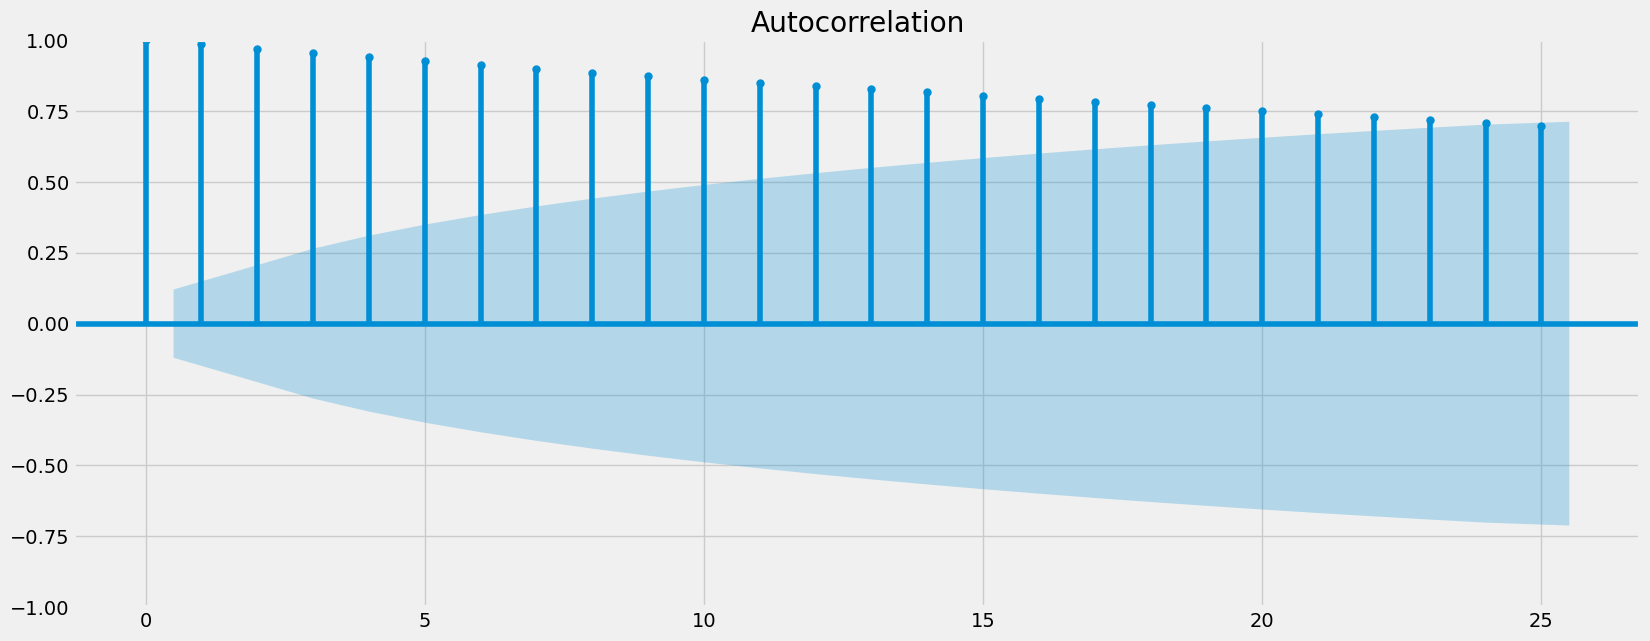

In [29]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(CPI_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that your data is non-stationary.

AS quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.

If your data still isn’t stationary, perform another round of differencing and repeat step 6.

Check your data’s autocorrelations.

Aince you know that you can’t forecast with non-stationary data, you first need to make it stationary. In order to do so, you’ll be running through some steps to extract the trend from your data by removing any unnecessary variance.

# Stationarizing FRED Time Series Data

Differencing

Log transformation

Combinations of both

The function df.shift(1) is essentially turning data into data - 1—or, to write it the same way as the formula above, t-1. So you subtract data - 1 from data (the previous data point from the given data point) to achieve the new value, which is then stored within a new dataframe, data_diff. You can think of these points as the quarters (in the year) when the observations about unemployment rate were made.

Once this is complete, you also need to remove a few values that resulted from the subtraction (mainly, any NaNs that resulted, for instance, from trying to subtract a non-existent value from the first value). 

In [30]:
CPI_diff = CPI_sub - CPI_sub.shift(1) 

In [31]:
# Remove missing values that come as a result of differencing
CPI_diff.dropna(inplace = True)

In [32]:
CPI_diff.head()

,Value
datetime,
2000-02-01,0.7
2000-03-01,1.0
2000-04-01,-0.1
2000-05-01,0.3
2000-06-01,1.0


In [33]:
CPI_diff.columns

Index(['Value'], dtype='object')

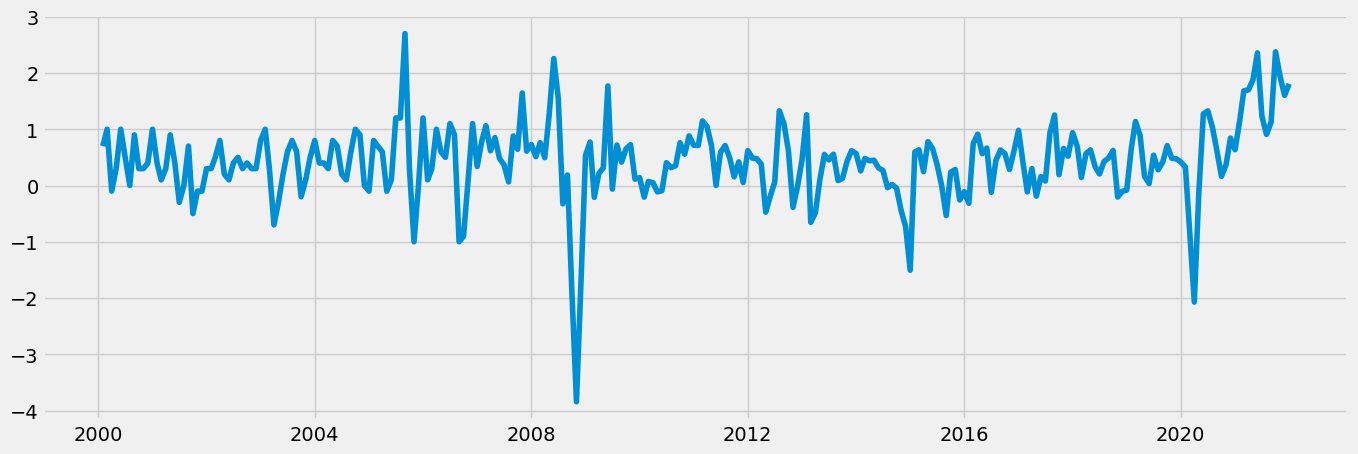

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(CPI_diff)

In [35]:
#Re-run Dickey-Fuller test
dickey_fuller(CPI_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.570757e+00
p-value                        2.291720e-16
Number of Lags Used            1.000000e+00
Number of Observations Used    2.620000e+02
Critical Value (1%)           -3.455558e+00
Critical Value (5%)           -2.872636e+00
Critical Value (10%)          -2.572683e+00
dtype: float64


Result: Test Statistic = -9.570757e+00 now < Critical Values. Therefore, the null hypothesis is rejected and plot the data as stationary.

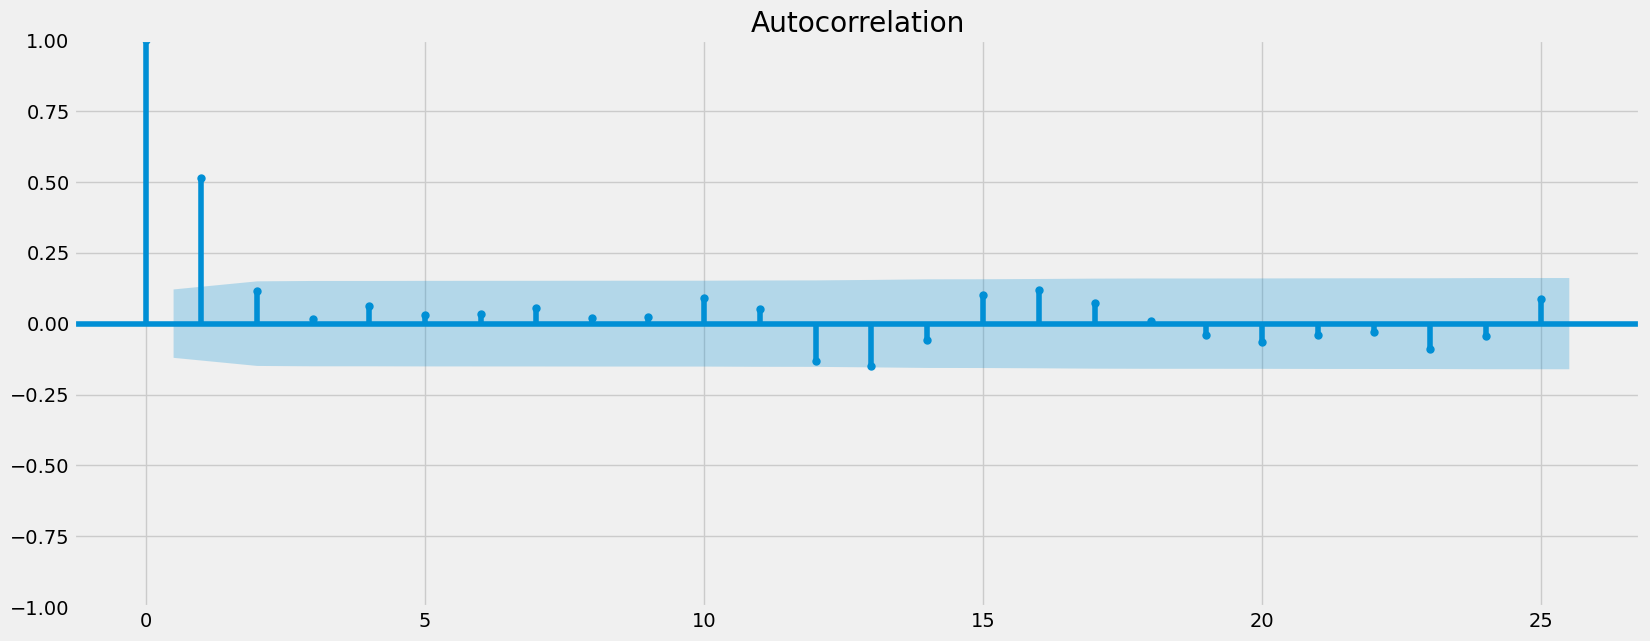

In [36]:
plot_acf(CPI_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that your data is stationary, that stationarity is weak. If you wanted, you could conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms.

One important note to make here is that after having conducted either of these techniques, you may end up with slightly overdifferenced or underdifferenced data.